# Assignment 4
Jiaqi Guo    JGR9647

In [ ]:
from datetime import datetime
import random
import gym
import numpy as np
from collections import deque

import pylab
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model

### Assignment Deep Q-Learning for Cartpole Balancing


In [15]:
# policy network
def OurModel(input_shape, action_space):
    X_input = Input(input_shape)

    # 'Dense' is the basic form of a neural network layer
    # Input Layer of state size(4) and Hidden Layer with 512 nodes
    X = Dense(512, input_shape=input_shape, activation="relu", kernel_initializer='he_uniform')(X_input)

    # Hidden layer with 256 nodes
    X = Dense(256, activation="relu", kernel_initializer='he_uniform')(X)

    # Hidden layer with 64 nodes
    X = Dense(64, activation="relu", kernel_initializer='he_uniform')(X)

    # Output Layer with # of actions: 2 nodes (left, right)
    X = Dense(action_space, activation="linear", kernel_initializer='he_uniform')(X)

    model = Model(inputs=X_input, outputs=X, name='CartPole_DQN_model')
    # model.compile(loss="mse", optimizer=RMSprop(lr=0.00025, rho=0.95, epsilon=0.01), metrics=["accuracy"])
    model.compile(loss='mse', optimizer=Adam(lr=0.00025))
    # model.summary()
    return model


class DQNAgent:
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        # by default, CartPole-v1 has max episode steps = 500
        self.state_size = self.env.observation_space.shape[0]
        self.action_size = self.env.action_space.n
        self.EPISODES = 300
        self.memory = deque(maxlen=2000)

        self.gamma = 0.99  # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.999
        self.batch_size = 64
        self.train_start = 1000

        # create main model
        self.model = OurModel(input_shape=(self.state_size,), action_space=self.action_size)
        self.target_model = OurModel(input_shape=(self.state_size,), action_space=self.action_size)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if len(self.memory) > self.train_start:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # implement the epsilon-greedy policy
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # implement the Q-learning
    def replay(self):
        if len(self.memory) < self.train_start:
            return
        # Randomly sample minibatch from the memory
        minibatch = random.sample(self.memory, min(len(self.memory), self.batch_size))

        state = np.zeros((self.batch_size, self.state_size))
        next_state = np.zeros((self.batch_size, self.state_size))
        action, reward, done = [], [], []

        # assign data into state, next_state, action, reward and done from minibatch
        for i in range(self.batch_size):
            state[i] = minibatch[i][0]
            action.append(minibatch[i][1])
            reward.append(minibatch[i][2])
            next_state[i] = minibatch[i][3]
            done.append(minibatch[i][4])

        # compute value function of current(call it target) and value function of next state(call it target_next)
        target = self.model.predict(state)
        target_val = self.target_model.predict(next_state)

        for i in range(self.batch_size):
            # correction on the Q value for the action used,
            # if done[i] is true, then the target should be just the final reward
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.gamma * (
                    np.amax(target_val[i]))

        # Train the Neural Network with batches where target is the value function
        self.model.fit(state, target, batch_size=self.batch_size,
                       epochs=1, verbose=0)

    def load(self, name):
        self.model = load_model(name)

    def save(self, name):
        self.model.save(name)

    def training(self):
        scores, episodes = [], []
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            score = 0
            i = 0
            while not done:
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)

                next_state = np.reshape(next_state, [1, self.state_size])
                if not done or i == 499:
                    reward = reward  # Reward --> +1
                else:
                    reward = -100  # Reward = -100

                self.remember(state, action, reward, next_state, done)
                self.replay()

                score += reward
                state = next_state

                i += 1
                if done:
                    dateTimeObj = datetime.now()
                    timestampStr = dateTimeObj.strftime("%H:%M:%S")

                    self.update_target_model()
                    score = score if score == 500 else score + 100

                    scores.append(score)
                    episodes.append(e)


                    print("episode: {}/{}, score: {}, e: {:.2}, time: {}".format(e + 1, self.EPISODES, i, self.epsilon,
                                                                                 timestampStr))
                    if np.mean(scores[-min(10, len(scores)):]) > 490:
                        return episodes, scores
                        # sys.exit()
        return episodes, scores


      # pylab.savefig("./save_graph/cartpole_dqn.png")

    # test function if you want to test the learned model
    def test(self):
        self.load("./save/cartpole-dqn-training.h5")
        for e in range(self.EPISODES):
            state = self.env.reset()
            state = np.reshape(state, [1, self.state_size])
            done = False
            i = 0
            while not done:
                # self.env.render()
                action = np.argmax(self.model.predict(state))
                next_state, reward, done, _ = self.env.step(action)
                state = np.reshape(next_state, [1, self.state_size])
                i += 1
                if done:
                    print("episode: {}/{}, score: {}".format(e + 1, self.EPISODES, i))
                    break

In [ ]:
agent = DQNAgent()
episodes, scores = agent.training()
# agent.test()

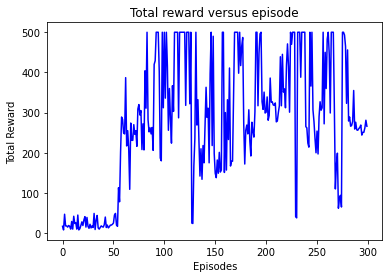

In [17]:
pylab.plot(episodes, scores, 'b')
pylab.title('Total reward versus episode')
pylab.xlabel('Episodes')
pylab.ylabel('Total Reward')
pylab.show()